In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/ColabNotebooks/AN2DL/Homework1/

/gdrive/MyDrive/ColabNotebooks/AN2DL/Homework1


In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
img_height=96
img_width=96
batch_size=8
data_dir='training_data_final'

train_ds = tfk.utils.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    color_mode="rgb",
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tfk.utils.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    color_mode="rgb",
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names

NameError: ignored

In [ ]:
# Labels of the dataset for classification
labels = {0:"Species1",              # 0
          1:"Species2",              # 1
          2:"Species3",              # 2
          3:"Species4",              # 3
          4:"Species5",              # 4
          5:"Species6",              # 5
          6:"Species7",              # 6
          7:"Species8"}              # 7

In [ ]:
model_d=DenseNet201(weights='imagenet',include_top=False, input_shape=(96, 96, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(8,activation='softmax')(x) #FC-layer

model=Model(inputs=model_d.input,outputs=preds)
model.summary()

74836368/74836368 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 48, 48, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1/conv[0][0]']             
                             

In [ ]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 48, 48, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

In [ ]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("training_data_final/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("training_data_final/"+img)))
    for i in path:
        image = cv2.imread("training_data_final/"+img+'/'+i)
        image = cv2.resize(image, (96,96))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['Species4', 'Species5', 'Species7', 'Species8', 'Species3', 'Species6', 'Species1', 'Species2']


In [ ]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0 0 0]


In [ ]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(2833, 96, 96, 3) (709, 96, 96, 3)


In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=50,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.38079, saving model to model.h5
22/22 - 41s - loss: 2.2444 - accuracy: 0.3623 - val_loss: 1.3808 - val_accuracy: 0.5439 - lr: 0.0010 - 41s/epoch - 2s/step
Epoch 2/50

Epoch 2: val_loss improved from 1.38079 to 1.18879, saving model to model.h5
22/22 - 13s - loss: 1.6349 - accuracy: 0.5009 - val_loss: 1.1888 - val_accuracy: 0.6117 - lr: 0.0010 - 13s/epoch - 610ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.18879 to 1.05459, saving model to model.h5
22/22 - 16s - loss: 1.4082 - accuracy: 0.5501 - val_loss: 1.0546 - val_accuracy: 0.6428 - lr: 0.0010 - 16s/epoch - 705ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.05459 to 1.00218, saving model to model.h5
22/22 - 13s - loss: 1.3271 - accuracy: 0.5523 - val_loss: 1.0022 - val_accuracy: 0.6707 - lr: 0.0010 - 13s/epoch - 593ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.00218 to 0.94872, saving model to model.h5
22/22 - 15s - loss: 1.2972 - accuracy: 0.5701 - val_loss: 

In [ ]:
# Saving the last epoch of the train
save_dir = os.path.join('DenseNet201')
model.save(save_dir)

In [ ]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

23/23 [==============================] - 2s 84ms/step
Total-test-data; 709 	accurately-predicted-data: 535 	 wrongly-predicted-data:  174
Accuracy: 75.458 %


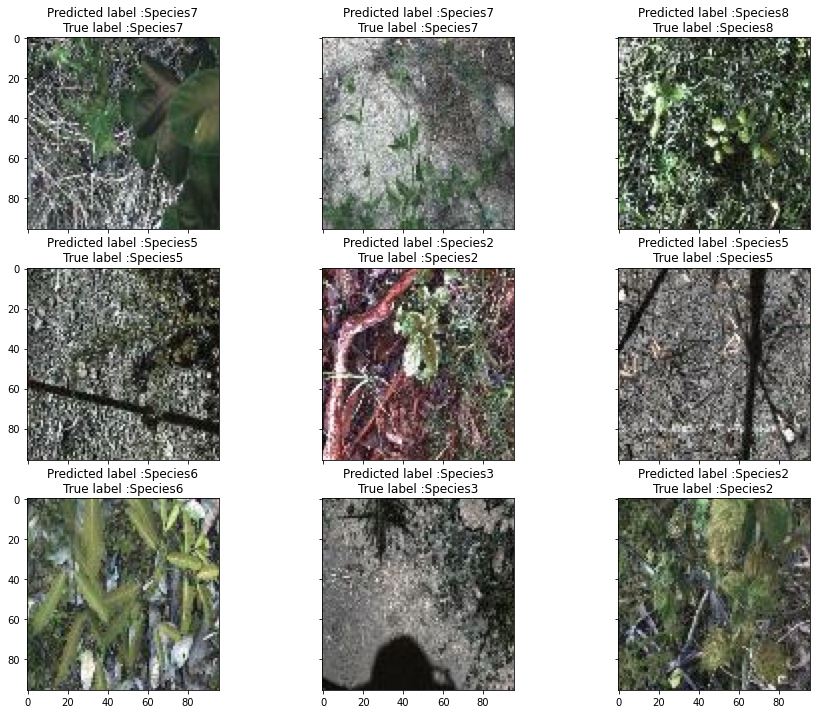

In [ ]:
label=['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

23/23 [==============================] - 1s 55ms/step


Text(0.5, 145.31999999999996, 'Predicted')

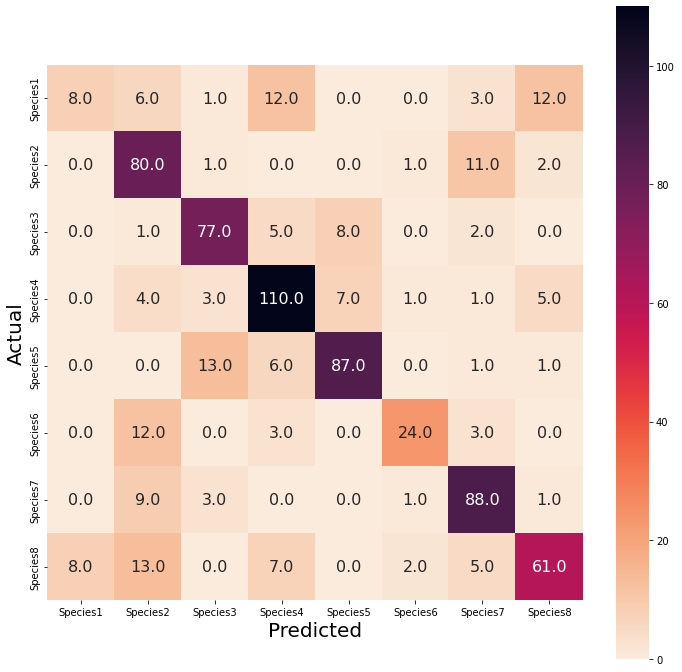

In [ ]:
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)